In [1]:
import numpy as np
import os

from standard_tester import *

from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.kern.matern32 import Matern32
from runlmc.kern.std_periodic import StdPeriodic
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)
xss, yss, test_xss, test_yss, cols = foreign_exchange_33k()

In [3]:
sum(map(len, xss)), sum(map(len, test_xss)) # train,test size

(33072, 2744)

In [4]:
cache_dir = '/tmp/'
inducing_points = [10]#np.arange(10, 150, 10)
num_runs = 1 # 5

In [5]:
import logging
from runlmc.models.lmc import LMC, _LOG
logging.getLogger().addHandler(logging.StreamHandler())
_LOG.setLevel(logging.INFO)

In [ ]:
m = 300
nk = 4
ks = [Matern32(name='mat{}'.format(i)) for i in range(nk)]
ranks= [1 for _ in range(nk)]
time, smse, nlpd, lmc = runlmc(
    1, m,
    xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 100, 'verbosity':10}, max_procs=40, prediction='precompute')

LMC lmc generating inducing grid n = 33072
LMC lmc grid (n = 33072, m = 304) complete, 
LMC lmc fully initialized


starting adadelta {'step_rate': 1, 'decay': 0.9, 'momentum': 0.5, 'offset': 0.0001, 'max_it': 100, 'verbosity': 10, 'min_grad_ratio': 0.5, 'roll': 1, 'permitted_drops': 5}
iteration       10 grad norm 9.2428e+02
iteration       20 grad norm 4.8820e+02
finished adadelta optimization
            24 iterations
    7.8464e+02 final grad norm
    7.8464e+02 final MA(1) grad norm
    1.9717e+03 max MA(1) grad norm
    norm used inf


Using 40 processors in parallel to precompute 3952 variance terms exactly
Exception in thread Thread-160:
Traceback (most recent call last):
  File "/memex/vyf/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/memex/vyf/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/memex/vyf/anaconda3/lib/python3.6/multiprocessing/pool.py", line 366, in _handle_workers
    pool._maintain_pool()
  File "/memex/vyf/anaconda3/lib/python3.6/multiprocessing/pool.py", line 240, in _maintain_pool
    self._repopulate_pool()
  File "/memex/vyf/anaconda3/lib/python3.6/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/memex/vyf/anaconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/memex/vyf/anaconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/memex/vyf/anaco

In [7]:
print(time, smse, nlpd)

81.9010924995 1.73555763809 -0.871715123386


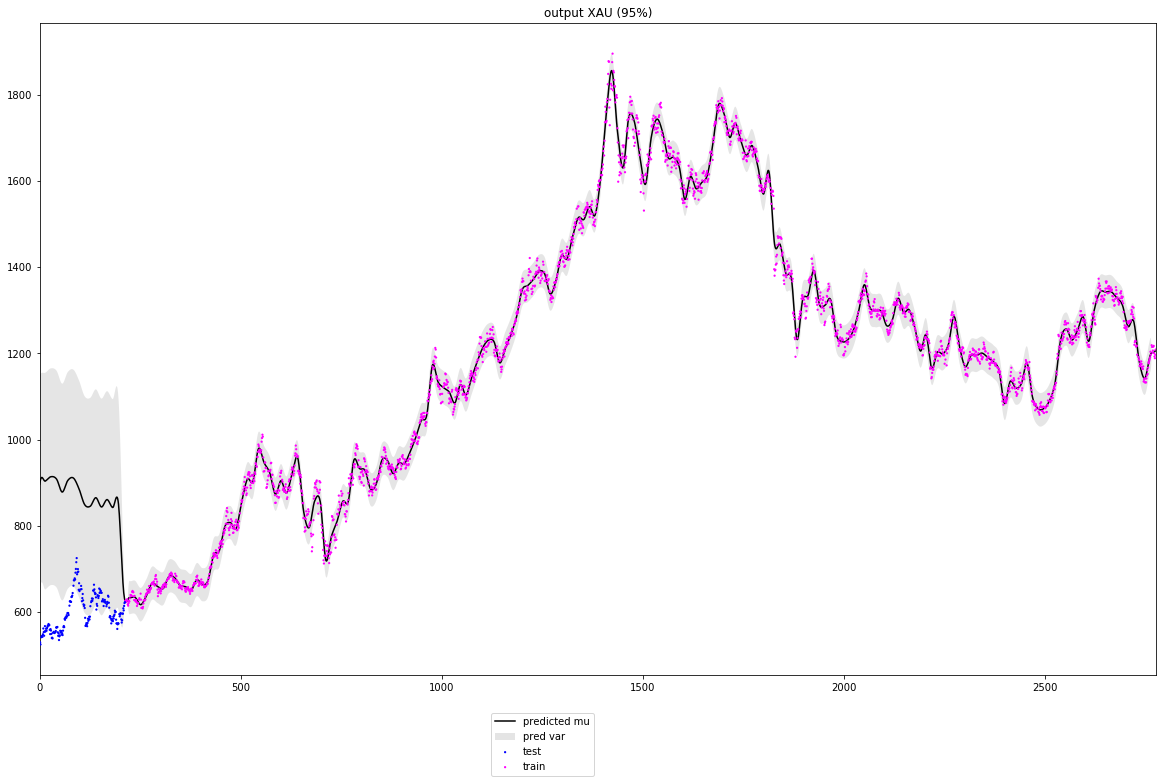

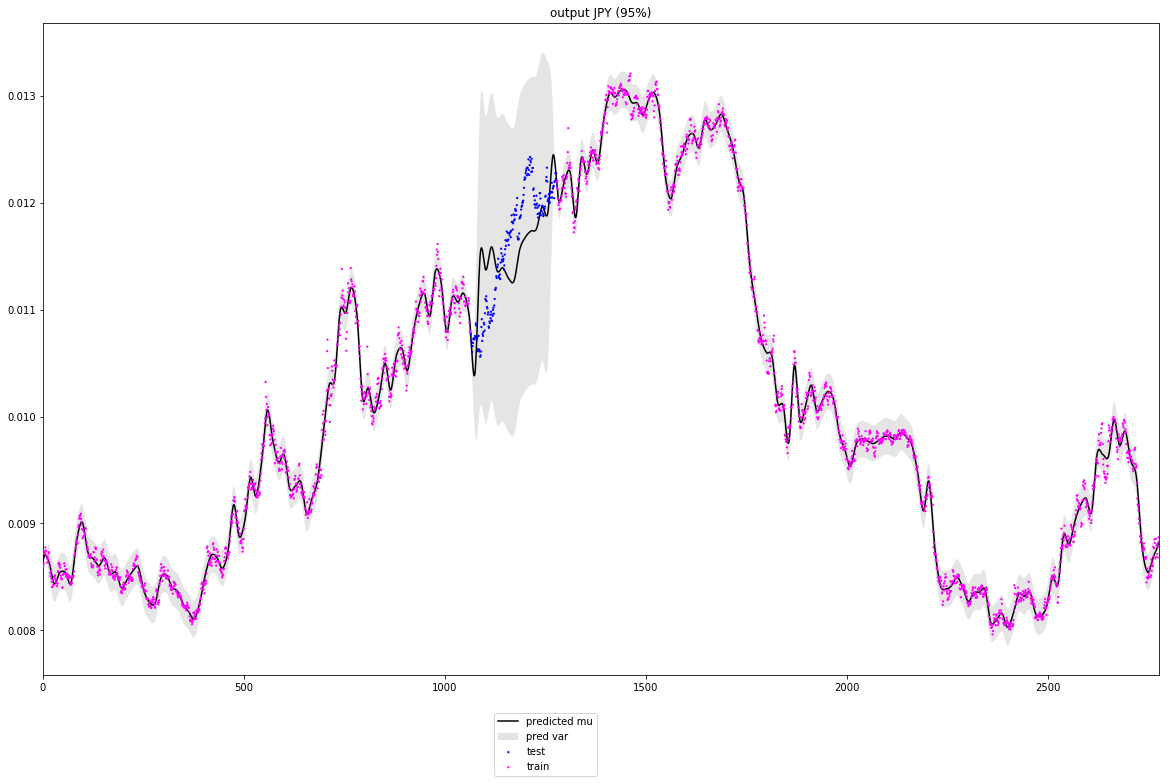

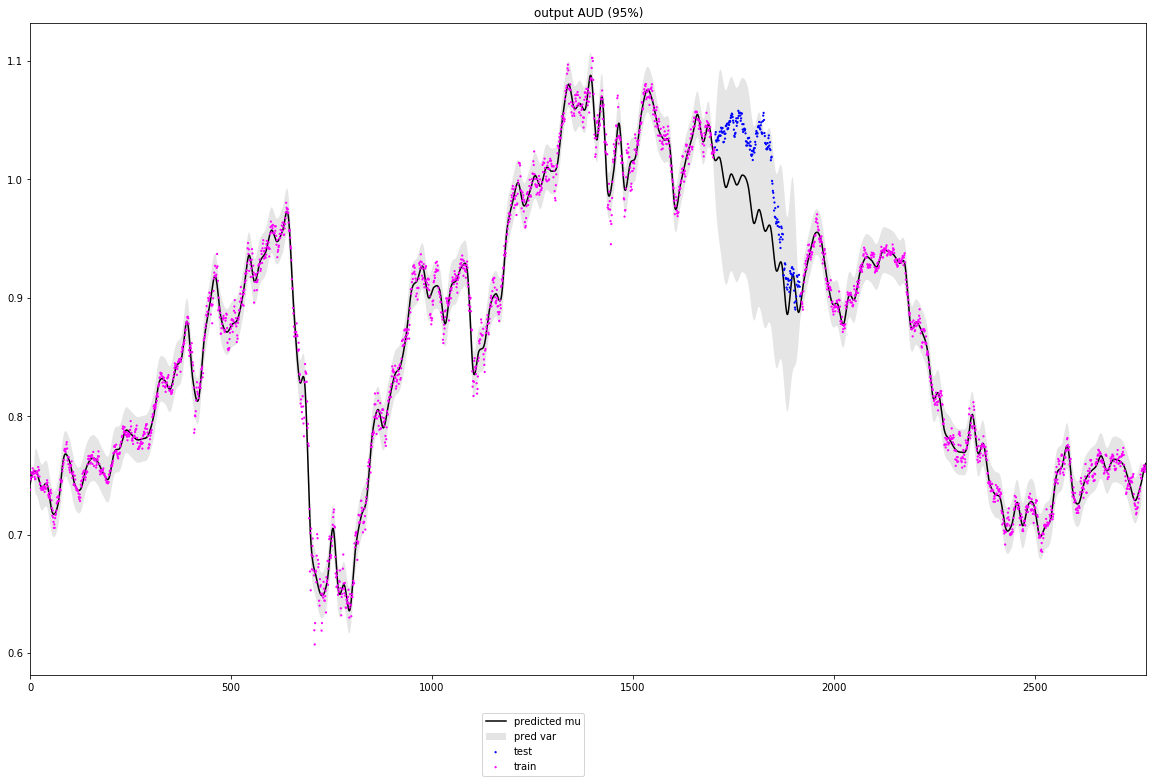

In [9]:
maxmax = max(xs.max() for xs in (xss + test_xss))
all_ixs = np.arange(maxmax)
pred_xss = [all_ixs for _ in cols]
pred_yss, pred_vss = lmc.predict(pred_xss)
for ix in [0, 5, 8]:
    pred_xs = pred_xss[ix]
    test_xs = test_xss[ix]
    pred_ys = pred_yss[ix]
    pred_vs = pred_vss[ix]
    test_ys = test_yss[ix]

    plt.figure(figsize=(20, 12))

    # Prediction for LLGP
    order = np.argsort(pred_xs)
    plt.plot(pred_xs[order], pred_ys[order], c='black', label='predicted mu')
    sd = np.sqrt(pred_vs)
    top = pred_ys + 2 * sd
    bot = pred_ys - 2 * sd
    plt.fill_between(pred_xs[order], bot[order], top[order], facecolor='grey', alpha=0.2, label='pred var')

    # Test
    marker_size = 5
    plt.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11, label='test')

    # Rest of image (training)
    rest_xs = xss[ix]
    rest_ys = yss[ix]
    plt.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10, label='train')

    plt.title('output {} (95%)'.format(cols[ix]))
    plt.xlim([0, max(test_xs.max(), xss[ix].max())])
    plt.legend(bbox_to_anchor=(.4, -.05), loc=2)
    from os.path import expanduser
    home = expanduser("~")
    plt.savefig(home + '/pics/m' + str(m) + '-' + cols[ix])
    plt.show()

In [ ]:
file_cached_vars = ['runlmc_times', 'runlmc_smses', 'runlmc_nlpds']
if all(os.path.isfile(cache_dir + file) for file in file_cached_vars):
    runlmc_times, runlmc_smses, runlmc_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in file_cached_vars]
else:
    runlmc_times, runlmc_smses, runlmc_nlpds = [], [], []
    for m in inducing_points:
        time, smse, nlpd, _ = runlmc(
            num_runs, m,
            xss, yss, test_xss, test_yss,
            ks, ranks, {'max_it': np.inf, 'verbosity':0})
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        runlmc_times.append(time)
        runlmc_smses.append(smse)
        runlmc_nlpds.append(nlpd)
    for i in file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))

In [ ]:
cogp_file_cached_vars = ['cogp_times', 'cogp_smses', 'cogp_nlpds']
if all(os.path.isfile(cache_dir + file) for file in cogp_file_cached_vars):
    cogp_times, cogp_smses, cogp_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in cogp_file_cached_vars]
else:
    cogp_num_runs = 2
    cogp_times, cogp_smses, cogp_nlpds = [], [], []
    for m in inducing_points:
        time, smse, nlpd = cogp_fx2007(cogp_num_runs, m)
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        cogp_times.append(time)
        cogp_smses.append(smse)
        cogp_nlpds.append(nlpd)
    for i in cogp_file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))        

In [ ]:
# note m means differnet things for LLGP and COGP
# -> use a time frontier graph
plt.plot(inducing_points, runlmc_times, label='LLGP')
plt.plot(inducing_points, cogp_times, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'run time vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('sec')
plt.show()
plt.plot(inducing_points, runlmc_smses, label='LLGP')
plt.plot(inducing_points, cogp_smses, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'standardized mean square error vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('smse')
plt.show()
shift = min(min(runlmc_nlpds), min(cogp_nlpds))
assert shift < 0
shift = int(abs(shift) * 2)
plt.semilogy(inducing_points, np.array(runlmc_nlpds) + shift, label='LLGP')
plt.semilogy(inducing_points, np.array(cogp_nlpds) + shift, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'shifted negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd + {}'.format(shift))
plt.show()
plt.plot(inducing_points, np.array(runlmc_nlpds), label='LLGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd')
plt.show()